**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import os
import pickle
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

# import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform

# import custom functions
import sys
sys.path.append('/Users/dat/Library/CloudStorage/OneDrive-foryouandyourcustomers/GitHub/AutomatedPackagingCategories_Showcase/ml_packaging_classification/src')
import utils


In [4]:
SEED = 42

clf_name = "best_clf"

# Get current date and time
now = datetime.now()
# Format date and time
formatted_date_time = now.strftime("%Y-%m-%d_%H:%M:%S")
print(formatted_date_time)

2023-08-02_15:13:41


# Load data

In [5]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

In [6]:
df['material_number'] = df['material_number'].astype('object')

df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [7]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [8]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'Metal Cassette': 100,
    'Carton tube with or w/o': 100,
    'Wooden box': 100,
    'Fabric packaging': 100,
    'Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X_oversample, y_oversample = oversampler.fit_resample(X, y)

distribution_classes = y_oversample.value_counts()
print('\n')
print('Class distribution after oversmapling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap Folding Card': 2188, 'Plastic Pouch': 1904, 'Plastic bag with header': 1850, 'Plastic Cassette': 1708, 'Shrink film and insert o': 1499, 'Plastic Box': 1491, 'Unpacked': 1415, 'Skincard': 1143, 'Trap Card': 804, 'Cardb. Sleeve w - w/o Shr.': 676, 'Carton cover (Lid box)': 652, 'Case': 485, 'Tray Packer': 431, 'Cardboard hanger w/o bag': 400, 'Envelope': 295, 'Countertop display': 150, 'Metal Cassette': 50, 'Carton tube with or w/o': 44, 'Wooden box': 16, 'Fabric packaging': 15, 'Book packaging': 10}


Class distribution after oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap 

In [9]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversample, y_oversample, test_size=0.2, stratify=y_oversample,
    # random_state=SEED
)

# Best model pipeline

In [10]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_params = {
    'n_estimators': 500,
    'max_depth': 20,
    'criterion': 'entropy'
}

best_model = RandomForestClassifier(
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

# Training
best_model.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(class_weight={0: 0.3286731902097557,
                                     1: 0.36320204826496705,
                                     2: 28.738362068965518,
                                     3: 4.249665370641851,
                                     4: 7.1845905172413795,
                                     5: 4.404346677236094,
                                     6: 28.738362068965518, 7: 5.92543547813722,
                                     8: 0.7421139333496583,
                                     9: 19.15890804597701,
                                     10: 9.741817650496786,
                                     11: 28.738362068965518,
                                     12: 0.349668283728858,
                                     13: 0.2122086916667197,
                                     14: 28.738362068965518,
                                     15: 0.8264086863829049,
                                     16: 1.9271324103245946,
                                     17: 1.6830665926187711,
                                     18: 1.5095659655398828,
                                     19: 1.5534249767008388,
                                     20: 1.9174887118575825,
                                     21: 2.5153927412661283,
                                     22: 0.34640183298436666,
                                     23: 3.5755349385960207,
                                     24: 1.3137536945812809,
                                     25: 6.663968015992004,
                                     26: 0.24588972893232527,
                                     27: 2.0309796515169976,
                                     28: 28.738362068965518},
                       criterion='entropy', max_depth=20, n_estimators=500)

In [11]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = best_model.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", best_model.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", best_model.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  0.955559221873922
Test score (f1-score):  0.791889135521027
                            precision    recall  f1-score   support

   Blister and Insert Card       0.77      0.79      0.78      1749
  Blister and sealed blist       0.77      0.78      0.78      1582
            Book packaging       1.00      1.00      1.00        20
Cardb. Sleeve w - w/o Shr.       0.50      0.43      0.46       135
  Cardboard hanger w/o bag       0.30      0.55      0.39        80
    Carton cover (Lid box)       0.51      0.56      0.54       130
   Carton tube with or w/o       0.83      0.75      0.79        20
                      Case       0.35      0.60      0.44        97
         Corrugated carton       0.79      0.73      0.76       774
        Countertop display       0.68      0.57      0.62        30
                  Envelope       0.91      0.90      0.91        59
          Fabric packaging       1.00      1.00      1.00        20
            Folding carton    

In [12]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,0.999888
1,TightPack,TightPack,0.450559
2,Folding carton,Folding carton,0.990629
3,Paperboard pouch,Paperboard pouch,0.996447
4,Shrink film and insert o,Shrink film and insert o,0.696006
5,Blister and sealed blist,Blister and Insert Card,0.626920
6,Plastic Box,Plastic Box,0.998000
7,Hanger/ Clip,Hanger/ Clip,0.997409
8,Hanger/ Clip,Hanger/ Clip,0.999907
9,Blister and sealed blist,Blister and sealed blist,1.000000


# Business Decision Optimization

<Figure size 1000x500 with 0 Axes>

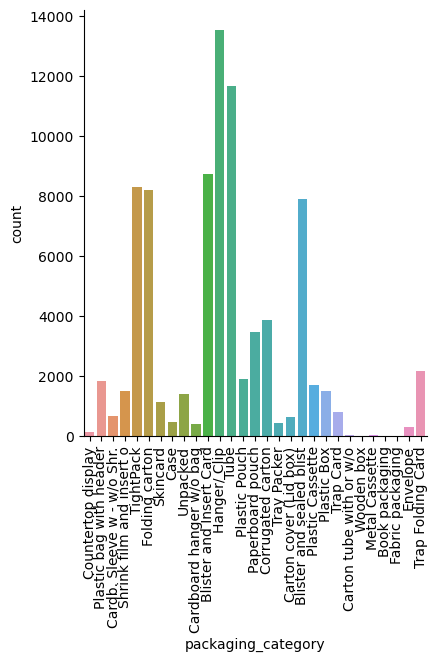

In [13]:
# class distribution (after oversampling)
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

## Threshold analysis (since best model provides probabilistic forecasts)

In [14]:
df_y_test.head()

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,0.999888
1,TightPack,TightPack,0.450559
2,Folding carton,Folding carton,0.990629
3,Paperboard pouch,Paperboard pouch,0.996447
4,Shrink film and insert o,Shrink film and insert o,0.696006


In [51]:
# threshhold None
# best_mode_clf_report = classification_report(df_y_test.y_test, df_y_test.preds_y_test, output_dict=True)
print(classification_report(df_y_test.y_test, df_y_test.preds_y_test))

                            precision    recall  f1-score   support

   Blister and Insert Card       0.77      0.79      0.78      1749
  Blister and sealed blist       0.77      0.78      0.78      1582
            Book packaging       1.00      1.00      1.00        20
Cardb. Sleeve w - w/o Shr.       0.50      0.43      0.46       135
  Cardboard hanger w/o bag       0.30      0.55      0.39        80
    Carton cover (Lid box)       0.51      0.56      0.54       130
   Carton tube with or w/o       0.83      0.75      0.79        20
                      Case       0.35      0.60      0.44        97
         Corrugated carton       0.79      0.73      0.76       774
        Countertop display       0.68      0.57      0.62        30
                  Envelope       0.91      0.90      0.91        59
          Fabric packaging       1.00      1.00      1.00        20
            Folding carton       0.78      0.70      0.74      1644
              Hanger/ Clip       0.88      0.95

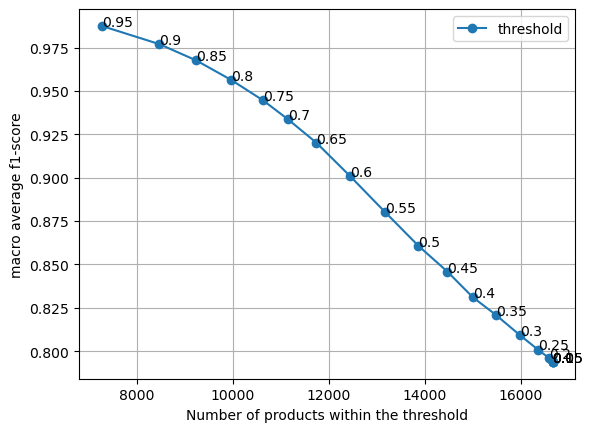

In [86]:
def threshold_analysis(thresholds: list, df_y_test: pd.DataFrame):

    # calculate individual clf reports for the data (products) that fulfill the threshold condition
    clf_reports = []

    for threshold in thresholds:
        df_y_test_threshold = df_y_test.loc[
            df_y_test.proba_preds_y_test >= threshold
        ]

        clf_report = classification_report(df_y_test_threshold.y_test, df_y_test_threshold.preds_y_test, output_dict=True)
        clf_reports.append(clf_report)

    # plot threshold curve
    f1_scores = []
    supports = []

    for j, clf_report in enumerate(clf_reports):
        f1_scores.append(clf_report['weighted avg']['f1-score'])
        supports.append(clf_report['weighted avg']['support'])

    plt.plot(supports, f1_scores, 'o-', label='threshold')
    for i, txt in enumerate(thresholds):
        plt.annotate(txt, (supports[i], f1_scores[i])) # Adding the annotation
    plt.legend()
    plt.grid()
    plt.xlabel('Number of products within the threshold')
    plt.ylabel('weighted average f1-score')
    plt.show()
    
    return clf_reports


# thresholds = [0, 0.80, 0.85, 0.90, 0.95]
thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

clf_reports = threshold_analysis(thresholds=thresholds, df_y_test=df_y_test)

## Consideration of class values from a business perspective

In [30]:
first_level_categories = [
    'Blister and Insert Card',
    'Hanger/ Clip',
    'Plastic Cassette',
    'Tube',
    'Blister and sealed blist',
    'Case',
    'TightPack',
    'Shrink film and insert o',
    'Plastic Pouch',
    'Plastic Box',
    'Plastic bag with header',
    'Skincard',
]

second_level_categories = [
    'Cardb. Sleeve w - w/o Shr.', 
    'Folding carton', 
    'Unpacked', 
    'Cardboard hanger w/o bag',
    'Paperboard pouch',
    'Corrugated carton', 
    'Tray Packer',
    'Carton cover (Lid box)', 
    'Trap Card',
    'Carton tube with or w/o', 
    'Wooden box',
    'Metal Cassette', 
    'Book packaging', 
    'Fabric packaging',
    'Envelope', 
    'Trap Folding Card'
]

# create subset based on most categorie importance
print('shape df_sub: ', df_sub.shape)
df_first_level = df_sub.loc[df_sub.packaging_category.isin(first_level_categories)]
print('shape df_first_level: ', df_first_level.shape)
df_second_level = df_sub.loc[df_sub.packaging_category.isin(second_level_categories)]
print('shape df_second_level: ', df_second_level.shape)
df_third_level = df_sub.loc[
    (~df_sub.packaging_category.isin(first_level_categories)) &
    (~df_sub.packaging_category.isin(second_level_categories))
]
print('shape df_third_level: ', df_third_level.shape)
print('Shapes are consistant: ', df_sub.shape[0] == df_first_level.shape[0] + df_second_level.shape[0] + df_third_level.shape[0])

third_level_categories = list(df_third_level.packaging_category.unique())

shape df_sub:  (82977, 10)
shape df_first_level:  (60262, 10)
shape df_second_level:  (22565, 10)
shape df_third_level:  (150, 10)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

In [ ]:
# Create the confusion matrix
# confusion_matrix(y_test, preds_y)
confusion_matrix(y_test, preds_y_test_inverse)